# Predviđanje veza u mreži korz vrijeme


*Temporal link prediction* iliti *TLP*.


## Priprema okruženja


In [1]:
# Standardna Python biblioteka.
import copy
import functools
import math
import numbers
import warnings

# SciPy paketi.
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Paket Hyperopt.
import hyperopt as ho


In [2]:
%matplotlib inline


In [3]:
from tlp import *


Using numpy backend.


## Generiranje mreže s vremenskom dimenzijom


Mrežu definiramo kao matricu (na indeksu $ \left( i , j \right) $ je težina veze $ i $-tog čvora u prvoj domeni u vezi s $ j $-tim čvorom u drugoj domeni, pri čemu težina $ 0 $ označava da veze nema, a, ako je mreža bez težina, veze su označene težinom $ 1 $; ako su domene mreže iste i mreža je neusmjerena, matrica je simetrična), a stanja mreže kao tenzor kojemu su rezovi po zadnjoj dimenziji, gledani kao matrice, stanja mreže u određenom trenutku.

Zbog manjka izvora stvarnih podataka, mrežu ćemo generirati vlastoručno.


### Definicija parametara


In [4]:
M = 10
N = 10
T = 40


In [5]:
k = 4


### Generiranje slučajne mreže bez pretpostavke periodičnosti


Sljedeći dio k&ocirc;da (trenutno zakomentiran) služi zato da izračunamo norme komponenti tenzora čiji su elementi cijeli brojevi u intervalu $ \left[ 0 \mathinner{\ldotp \ldotp} 20 \right] $ tako da je očekivana popunjenost u svakom rezu po trećoj dimenziji $ 50 \, \% $. Inicijalno su svi brojevi iz intervala $ \left[ 1 \mathinner{\ldotp \ldotp} 20 \right] $ birani uniformno vjerojatno, zatim su oni među njima koji premašuju $ 10 $ s $ 50 $-postotnom vjerojatnosti umanjeni za $ 10 $, a, konačno, svaki element je u svakom rezu s $ 50 $-postotnom vjerojatnosti postavljen na $ 0 $.


In [6]:
# Z = np.random.randint(1, 21, size = (M, N, T), dtype = int).copy(order = 'F')
# for i in iter(range(T)):
#     for r in iter(range(M)):
#         for s in iter(range(N)):
#             if Z[r, s, i] > 10:
#                 if np.random.binomial(1, 0.5):
#                     Z[r, s, i] -= 10
#         try:
#             del s
#         except (NameError, UnboundLocalError):
#             pass
#     try:
#         del r
#     except (NameError, UnboundLocalError):
#         pass
#     Z[
#         np.random.binomial(
#             1,
#             0.5,
#             size = (M, N)
#         ).astype(bool).copy(order = 'F'),
#         i
#     ] = 0
# try:
#     del i
# except (NameError, UnboundLocalError):
#     pass


Od generiranog tenzora u sljedećoj čeliji računamo norme komponenti. Norme zatim spremamo u datoteku *lambda.npy*.


In [7]:
# from tensorly.decomposition import parafac as parafac

# cpd = list(parafac(Z.astype(float), k))

# l = np.ones(k, dtype = float, order = 'F')
# for i in iter(range(k)):
#     for j in iter(range(len(cpd))):
#         if (cpd[j][:, i] != 0).any():
#             l[i] *= np.linalg.norm(cpd[j][:, i])
#         else:
#             l[i] = 0
#     try:
#         del j
#     except (NameError, UnboundLocalError):
#         pass
# try:
#     del i
# except (UnboundLocalError):
#     pass
# l = np.flip(np.sort(l)).copy(order = 'F')

# del cpd

# np.save('data/lambda.npy', l)

# del parafac


### Generiranje slučajne mreže s pretpostavkom periodičnosti


Sljedeći dio koda služi za generiranje mreže u kojoj po trećoj dimenziji možemo donekle očekivati periodičnost. Mrežu generiramo tako da generiramo njen rastav na komponente, a zatim te komponente množimo u tenzor (mrežu). Na kraju osiguravamo da su vrijednosti u mreži cjelobrojne i iz intervala $ \left[ 0 \mathinner{\ldotp \ldotp} 20 \right] $. Rastav na komponente inspiriran je *CP* dekompozicijom tenzora, ali nije garantirano da će komponente uistinu biti one koje bi se dobile *CP* dekompozicijom. Ipak, treće komponente ponašat će se periodički (uz dodani šum), a ta periodičnost zadržat će se u tenzoru dobivenom kombiniranjem generiranih komponenti, stoga očekujemo periodičnost trećih komponenti dobivenih *CP* dekompozicijom dobivenog tenzora.


Učitajmo norme komponenti tenzora kojeg ćemo generirati.


In [8]:
l = None
l0 = np.load('data/lambda.npy').ravel()
h = int(round(math.ceil(float(l0.size) / k)))
l = np.zeros(h * k, dtype = l0.dtype, order = 'C')
l[:l0.size] = l0
l = l.reshape((h, k)).sum(axis = 0).copy(order = 'F')
del l0
del h


Učitajmo *očekivanja* i *standardne devijacije* za generiranje diskretnih Fourireovih transformacija kojima ćemo generirati periodične nizove.


In [9]:
mu = (np.load('data/mu_real.npy'), np.load('data/mu_imag.npy'))
sigma = (np.load('data/sigma_real.npy'), np.load('data/sigma_imag.npy'))


Sljedeći parametri služe za generiranje treće komponente iz koeficijenata diskretne Fourierove transformacije. Parametar `m` prosljeđuje se funkciji `numpy.fft.irfft` kao duljina niza koji se generira, parametar `n` prosljeđuje se funkciji `rand_fft` kao broj koeficijenata koji se generiraju, a parametar `t` definira *šum*: svakom se generiranom nizu dodatno zbrajaju vrijednosti slučajno birane po normalnoj distribuciji s očekivanjem $ 0 $ i standardnom devijacijom `t * std` gdje je `std` standardna devijacija te komponte nakon diskretizacije na `T` točaka, ali prije normiranja.


In [10]:
m = 1025
n = 32
t = 0.5


Generirajmo prve i druge komponente. Generiramo ih slučajnim biranjem vrijednosti normalnom distribucijom s očekivanjem $ 0 $ i varijancom $ 1 $, ali, negativne vrijednosti zatim postavljamo na $ 0 $, a komponente, naravno, normiramo.


In [11]:
a = np.random.randn(k, M).astype(float)
b = np.random.randn(k, N).astype(float)

for i in iter(range(k)):
    a[i, a[i] <= 0] = 0
    b[i, b[i] <= 0] = 0
    if (a[i] != 0).any():
        a[i, :] /= np.linalg.norm(a[i])
    else:
        a[i, :] = 0
    if (b[i] != 0).any():
        b[i, :] /= np.linalg.norm(b[i])
    else:
        b[i, :] = 0
try:
    del i
except (NameError, UnboundLocalError):
    pass

a = a.T.copy(order = 'F')
b = b.T.copy(order = 'F')


Generirajmo sada postepeno treće komponente. Prvo, funkcijama `rand_fft` i `numpy.fft.irfft` (s vjerojatnosti od $ 50 \, \% $ dobiveni niz pomnožimo s $ {- 1} $) generirajmo `k` komponenti duljine `m`.


In [12]:
c = np.array(
    [
        -1 ** np.random.binomial(1, 0.5) *
        np.fft.irfft(rand_fft(n, mu, sigma), n = m)
            for i in iter(range(k))
    ],
    dtype = float,
    order = 'F'
)
try:
    del i
except (NameError, UnboundLocalError):
    pass


Iz nizova duljine `m` ekstrahirajmo sada `T` ravnomjerno raspoređenih vrijednosti.


In [13]:
c_old = c.copy(order = 'F')
c = np.zeros((k, T + 1), dtype = float, order = 'F')
if not T:
    c[:, 0] = c_old.mean(axis = 1)
else:
    for i in iter(range(int(c.shape[1]))):
        j = float(i) / T * int(c_old.shape[1] - 1)
        c[:, i] = (
            c_old[:, int(math.floor(j))] +
            (j - math.floor(j)) * (
                c_old[:, int(math.ceil(j))] - c_old[:, int(math.floor(j))]
            )
        )
        del j
    try:
        del i
    except (NameError, UnboundLocalError):
        pass
c = c[:, :-1].copy(order = 'F')
del c_old


Dodajmo tim komponentama sada i šum.


In [14]:
for i in iter(range(k)):
    std = None
    try:
        std = c[i].std(ddof = 1)
        if std is None:
            std = 0.0
    except ValueError:
        std = 0.0
    c[i] += t * std * np.random.randn(c.shape[1])
    del std
try:
    del i
except (NameError, UnboundLocalError):
    pass


Normirajmo sada treće komponente, ali prije toga, po volji, tretirajmo negativne vrijednosti. Trenutno su predložene opcije (zakomentirane linije) uzimanje apsolutnih vrijednosti elemenata komponenti, translacija komponenti tako da im je najmanja postignuta vrijednost $ 0 $ i postavljanje svih negativnih vrijednosti na $ 0 $.


In [15]:
for i in iter(range(k)):
#   c[i, :] = np.abs(c[i])
#   c[i, :] -= c[i].min()
#   c[i, c[i] <= 0] = 0
    if (c[i] != 0).any():
        c[i] /= np.linalg.norm(c[i])
    else:
        c[i, :] = 0
try:
    del i
except (NameError, UnboundLocalError):
    pass


Konačno, pretvorimo treće komponente u stupce umjesto redaka.


In [16]:
c = c.T.copy(order = 'F')


Demonstracije radi, prikažimo treće komponente grafički. Periodičnost bi se trebala nazirati, ali bi trebala biti iskvarena ovisno o šumu zadanom parametrom `t`.


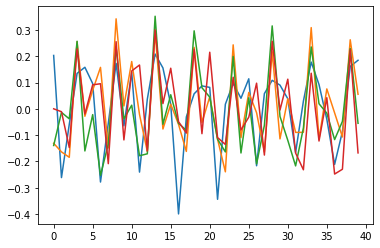

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)

for i in iter(range(k)):
    ax.plot(c[:, i])
try:
    del i
except (NameError, UnboundLocalError):
    pass
plt.show()


In [18]:
del fig
del ax


Nakon što smo generirali normirane komponente, izmnožimo ih u tenzor. Zatim *rastegnimo* odnosno *kontrahirajmo* vrijednosti u dobivenom vrijednosti tako da $ 80 $-i centil postavimo na $ 20 $ ako je on strogo pozitivan (u protivnom tenzor samo izmnožimo s $ 20 $), zaokružimo vrijednosti u tenzoru na cijele brojeve, vrijednosti veće od $ 20 $ umanjujemo za $ 20 $ dok ne premašuju $ 20 $ i na kraju sve negativne vrijednosti postavimo na $ 0 $.


In [19]:
Z = np.zeros((M, N, T), dtype = float).copy(order = 'F')
for i in iter(range(k)):
    Z += (
        l[i] *
        a[:, i].reshape((M, 1, 1)) *
        b[:, i].reshape((1, N, 1)) *
        c[:, i].reshape((1, 1, T))
    )
try:
    del i
except (NameError, UnboundLocalError):
    pass
H = np.percentile(Z, 80)
if H <= 0:
    Z = 20 * Z
else:
    Z = 20 * Z / H
Z = Z.round().astype(int).copy(order = 'F')
while (Z > 20).any(): # vjerojatno se može pametnije uz upotrebu operatora %
    Z[Z > 20] -= 20   # odnosno %=
Z[Z <= 0] = 0


Provjerimo *popunjenost* generiranog tenzora (udio njegovih elemenata različitih od $ 0 $).

***Napomena.*** Ukupna popunjenost ne znači da je tolika popunjenost u svakom rezu po zadnjoj dimenziji, kao što smo radili kod generiranja mreže bez pretpostavke periodičnosti.


In [20]:
100.0 * float((Z > 0).sum(dtype = float) / Z.size)


34.35

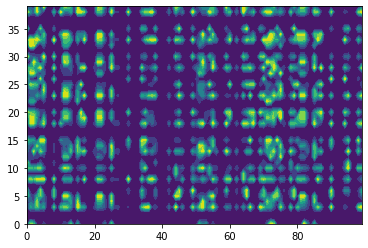

In [21]:
U, V = np.meshgrid(np.arange(M * N, dtype = int), np.arange(T, dtype = int))
W = np.array(
    [Z[:, :, i].ravel() for i in iter(range(int(Z.shape[2])))],
    dtype = float,
    order = 'F'
)
try:
    del i
except (NameError, UnboundLocalError):
    pass

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.contourf(U, V, W)
plt.show()


In [22]:
del fig
del ax
del U
del V
del W
